# Q1: *Using linguistic cues, is it possible to detect betrayal?*

This notebook contains the code for training 3 simple models:
   - Logistic Regression
   - Random Forest Classifier
   - Gradient Boosting Classifier
    

and a Fully Connected Linear Network for predicting if a game in a Dimplomacy games end with betrayal. 

In [27]:
import torch
import json
import random
import sklearn
import numpy as np
from io import open
from helpers import *
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [28]:
# reading the diplomacy data and setting the random seed so that the notebook can be reproducable.
random.seed(5)
with open("data/diplomacy_data.json", "r") as f:
    diplomacy = json.load(f)

***FEATURE EXTRACTION***

The features are extracted from all the seasons before the last support season.

In [29]:
#We initialize the feature vecros and label vecors to all zeros
labels = np.empty((0))
whole_items = np.empty((0,12))
victim_items = np.empty((0,12))
betrayer_items = np.empty((0,12))

whole_items_e = np.empty((0,14))
victim_items_e = np.empty((0,14))
betrayer_items_e = np.empty((0,14))
for entry in diplomacy:
    seasons_all = np.empty((0,12))
    season_victim = np.empty((0,12))
    season_betrayer = np.empty((0,12))
    
    seasons_all_e = np.empty((0,14))
    season_victim_e = np.empty((0,14))
    season_betrayer_e = np.empty((0,14))
    for who in ["victim","betrayer"]:
        #Get all features for the season
        item_e = extract_features([entry],who,None,None,False)
        #We delete the features Claim and Temporal rest
        item = np.delete(item_e, (8,13),axis=0)
        item = np.transpose(item)
        item_e = np.transpose(item_e)
        seasons_all = np.concatenate((seasons_all,item), axis=0)
        
        seasons_all_e = np.concatenate((seasons_all_e,item_e), axis=0)
        
        if who == "victim":
            season_victim = np.concatenate((season_victim, item), axis=0)
            season_victim_e = np.concatenate((season_victim_e, item_e), axis=0)
        else:
            season_betrayer = np.concatenate((season_betrayer, item), axis=0)
            season_betrayer_e = np.concatenate((season_betrayer_e, item_e), axis=0)
            
    #Package the features into their respective arrays if we have any features  
    #Label is 1 if betrayal happened otherwise 0
    if len(seasons_all)!=0:   
        label_item = 0
        if entry["betrayal"]:
            label_item = 1     
        labels = np.concatenate((labels, [label_item]), axis=0)     
        
        whole_items = np.concatenate((whole_items, [np.mean(seasons_all,axis=0)]), axis=0)
        victim_items = np.concatenate((victim_items, [np.mean(season_victim,axis=0)]), axis=0)
        betrayer_items = np.concatenate((betrayer_items, [np.mean(season_betrayer,axis=0)]), axis=0)
        
        whole_items_e = np.concatenate((whole_items_e, [np.mean(seasons_all_e,axis=0)]), axis=0)
        victim_items_e = np.concatenate((victim_items_e, [np.mean(season_victim_e,axis=0)]), axis=0)
        betrayer_items_e = np.concatenate((betrayer_items_e, [np.mean(season_betrayer_e,axis=0)]), axis=0)

In [30]:
#By getting difference between betrayer and victim features we are getting the inbalance features.
#Normalizing the inbalance feateures using scale.
X_train_s = preprocessing.scale(betrayer_items - victim_items)
X_train_e = preprocessing.scale(betrayer_items_e - victim_items_e)
y_train = labels

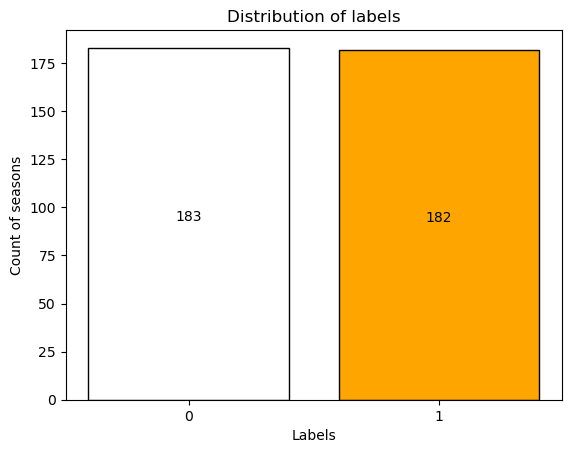

In [31]:
#Ploting the how many features that each class has.
width = 0.1
x=[0,0.25]
zeros = plt.bar(0, Counter(y_train)[0], label='No Betrayal',width=0.2,color='white',edgecolor="black")
ones = plt.bar(0.25,Counter(y_train)[1] , label='Betrayal',width=0.2,color='orange',edgecolor="black")
plt.text(zeros[0].get_x() + zeros[0].get_width()/2., zeros[0].get_height()/2,'%d' % int(zeros[0].get_height()),ha='center', va='bottom')
plt.text(ones[0].get_x() + ones[0].get_width()/2., ones[0].get_height()/2,'%d' % int(ones[0].get_height()),ha='center', va='bottom')
plt.xticks(x, ('0', '1'))

plt.title('Distribution of labels')
plt.xlabel("Labels")
plt.ylabel("Count of seasons")
plt.savefig("qA_imbalance_part1.png")
plt.show()

By looking at the plot we can say that our classes are balanced. Do we don't need to balance it.

***BASIC MODELS***

For the basic models everything, except model, will be the same. We used 5 fold cross-validation for the each model and  at the begining of the each cross-validation we used grid search for the finding best parameters with 5-fold cross-validation. So we used nested cross-validations. Moreover we are repeating the same experiment for both including the all features and excluding claim and temporal rest features.

Note: We are not tuning any parameters for the logistic regression so we are not using grid search for it.

- Logistic Regression

In [6]:
# for 5 fold CV with LogisticRegression
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)

    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #We are setting our model as logistic regression and setting our class weight as balanced since we have balanced classes for this classification task
        regressor = LogisticRegression(class_weight='balanced')
        #fitting the data into the model
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold))
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate accuracy 
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        #Calculate Matthews correlation coefficient
        r[i] = matthews_corrcoef(np.ravel(y_te_fold), y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, matthews_corrcoef:{}, Accuracy:{}, RMSE:{}, MAE:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' matthews_corrcoef ={} in i={},\n Accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
i:0, matthews_corrcoef:0.0421370524277137, Accuracy:0.5205479452054794, RMSE:0.6924247647178143, MAE:0.4794520547945205
i:1, matthews_corrcoef:0.2069230253146655, Accuracy:0.6027397260273972, RMSE:0.6302858668672515, MAE:0.3972602739726027
i:2, matthews_corrcoef:0.17134433865677873, Accuracy:0.589041095890411, RMSE:0.6410607647560324, MAE:0.410958904109589
i:3, matthews_corrcoef:0.21116138763197587, Accuracy:0.6027397260273972, RMSE:0.6302858668672515, MAE:0.3972602739726027
i:4, matthews_corrcoef:0.01938508771663481, Accuracy:0.5205479452054794, RMSE:0.6924247647178143, MAE:0.4794520547945205
Best results:
 matthews_corrcoef =0.21116138763197587 in i=3,
 Accuracy=0.6027397260273972 in i=1,
 RMSE=0.6302858668672515 in i=1,
 MAE=0.3972602739726027 in i=1
With feature set 2
-------------------------------
i:0, matthews_corrcoef:0.0421370524277137, Accuracy:0.5205479452054794, RMSE:0.6924247647178143, MAE:0.4794520547945205
i:1, matthews_

- Random Forest Classifier

In [7]:
# for 5 fold CV for parameter tuning with RandomForest
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as random forest classifier
    estimator = RandomForestClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
        'max_depth': [3, 6, 9, 18],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 400, 600, 800]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)

    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #we are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold)) # actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate accuracy 
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        #Calculate Matthews correlation coefficient
        r[i] = matthews_corrcoef(np.ravel(y_te_fold), y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, r:{}, Accuracy:{}, RMSE:{}, MAE:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' r ={} in i={},\n Accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
i:0, r:-0.13991822554907393, Accuracy:0.4246575342465753, RMSE:0.7585133260223084, MAE:0.5753424657534246
Best Parameters for 1 fold: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
i:1, r:0.0960960960960961, Accuracy:0.547945205479452, RMSE:0.6723502022908507, MAE:0.4520547945205479
Best Parameters for 2 fold: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
i:2, r:0.20331348358070708, Accuracy:0.6027397260273972, RMSE:0.6302858668672515, MAE:0.3972602739726027
Best Parameters for 3 fold: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
i:3, r:-0.02040821573377854, Accuracy:0.4931506849315068, RMSE:0.7119335046677415, MAE:0.5068493150684932
Best Parameters for 4 fold: {'max_depth': 3, 'min_samples_leaf': 2, 'min_sam

- Gradient Boosting Classifier

In [8]:
# for 5 fold CV for parameter tuning with GBR
#iterate over with and without claim and temporal rest features
for idx,(X_train,y_train)  in enumerate(zip([X_train_s,X_train_e],[y_train,y_train])):
    print(f'With feature set {idx+1}\n-------------------------------')
    #setting the estimator as gradient boosting classifier
    estimator = GradientBoostingClassifier()
    #setting the parameters which we will use them to tune the parameters and use them in the grid search
    parameters =  {
        'max_depth': [3, 6, 9, 18],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 4],
        'learning_rate' : [0.1,0.01,0.001,0.0001],
        'n_estimators': [100, 200, 400, 600, 800]}
    #Setting N to 5 means 5-fold cross-validation
    N = 5
    r = np.zeros(N)
    accuracy = np.zeros(N)
    RMSE = np.zeros(N)
    MAE=np.zeros(N)

    kf = KFold(n_splits=N)
    i=0
    for train_index, test_index in kf.split(X_train):
        #Seperating data as train and validation
        X_tr_fold, X_te_fold = X_train[train_index], X_train[test_index]
        y_tr_fold, y_te_fold = y_train[train_index], y_train[test_index]
        #We are setting the grid search(cv used for cross validation and set as 5 n_jobs=-1 so we will use the all processors available)
        grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, 
                              cv = N, n_jobs = -1)
        #fitting the data into the all sets of parameters
        grid_search.fit(X_tr_fold,np.ravel(y_tr_fold))
        # We are printing the best parameters for the current training set.
        print("Best Parameters for {} fold: {}".format(i,grid_search.best_params_))
        #we are getting the best estimator model
        regressor = grid_search.best_estimator_
        regressor.fit(X_tr_fold,np.ravel(y_tr_fold)) # actually this line is not needed since we are fitting all of the models but for just demosntration we are fitting anyway.
        #prediction over the current validation set
        y_predict = regressor.predict(X_te_fold)
        #Calculate accuracy 
        accuracy[i] = regressor.score(X_te_fold,y_te_fold)
        #Calculate Matthews correlation coefficient
        r[i] = matthews_corrcoef(np.ravel(y_te_fold), y_predict)
        #Calculate rmse and mae for extra information and comparison between models
        RMSE[i] = np.sqrt(sklearn.metrics.mean_squared_error(y_te_fold, y_predict))
        MAE[i] = sklearn.metrics.mean_absolute_error(y_te_fold, y_predict)
        print('i:{}, r:{}, Accuracy:{}, RMSE:{}, MAE:{}'.format(i, r[i],accuracy[i],RMSE[i], MAE[i]))
        i+=1
    #After getting the all results we are printing the best overall result over 5 different fold.
    print('Best results:')
    print(' r ={} in i={},\n Accuracy={} in i={},\n RMSE={} in i={},\n MAE={} in i={}'.format(np.amax(r), np.argmax(r), np.amax(accuracy), np.argmax(accuracy), np.amin(RMSE), np.argmin(RMSE), np.amin(MAE), np.argmin(MAE)))

With feature set 1
-------------------------------
Best Parameters for 0 fold: {'learning_rate': 0.0001, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
i:0, r:0.014757211941301602, Accuracy:0.4931506849315068, RMSE:0.7119335046677415, MAE:0.5068493150684932
Best Parameters for 1 fold: {'learning_rate': 0.01, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
i:1, r:0.17881297308221347, Accuracy:0.589041095890411, RMSE:0.6410607647560324, MAE:0.410958904109589
Best Parameters for 2 fold: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
i:2, r:0.22669007636449928, Accuracy:0.6164383561643836, RMSE:0.6193235372853323, MAE:0.3835616438356164
Best Parameters for 3 fold: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 800}
i:3, r:0.09706571005669763, Accuracy:0.547945205479452, RMSE:0.6723502022908507, MAE:0.452

***NEURAL NETWORK***

- Fully Connected Linear Network

In [9]:
NO_EPOCH = 100

In [10]:
#We create the input features required for the Neural Network model
#For the nn we are using different features which is basically concatination of mean features of each game and mean inbalance vector of each game.
features_s = np.concatenate((whole_items,np.absolute(betrayer_items - victim_items)), axis=1)
features_e = np.concatenate((whole_items_e,np.absolute(betrayer_items_e - victim_items_e)), axis=1)
labels =np.array(labels)
#Suffle the data and labels
rand_idx=np.random.permutation(len(features_s))
features_s = features_s[rand_idx]
features_e = features_e[rand_idx]
labels = labels[rand_idx]

In [11]:
#For faster training we are checking if the cuda is avaliable for the current machine
cuda_is_available = torch.cuda.is_available()

We perform Grid search on batch size and learning rate parameters.

Since we have very few samples, We use cross-validation in order to validate our traininig results.

Then,we save the results into memory.

In [26]:
#Here we use only 12 features(Temporal rest and claim are omitted)
#Due to concatanation it comes out as 24 features per sample
final_stat_s=[]
epoch_stat_s=[]
ms_arr_s=[]
for batch_size,lr in product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]):
    final_stat,epoch_stat, ms_arr = cross_validation(24,labels, features_s, 5, NO_EPOCH, batch_size,lr,cuda_is_available,False,None)
    final_stat_s.append(final_stat)
    epoch_stat_s.append(epoch_stat)
    ms_arr_s.append(ms_arr)
np.save('qA_final_stat_s.npy', np.array(final_stat_s))
np.save('qA_epoch_stat_s.npy', np.array(epoch_stat_s))
np.save('qA_ms_arr_s.npy', np.array(ms_arr_s))

[1,    99] loss: 1.977575
[1,   199] loss: 0.702052
[2,    99] loss: 0.820040
[2,   199] loss: 0.702344
[3,    99] loss: 0.712779
[3,   199] loss: 0.702214
[4,    99] loss: 0.712855
[4,   199] loss: 0.702296
[5,    99] loss: 0.712894
[5,   199] loss: 0.702340
[6,    99] loss: 0.712918
[6,   199] loss: 0.702367
[7,    99] loss: 0.712932
[7,   199] loss: 0.702384
[8,    99] loss: 0.712942
[8,   199] loss: 0.702395
[9,    99] loss: 0.712949
[9,   199] loss: 0.702403
[10,    99] loss: 0.712954
[10,   199] loss: 0.702409
[11,    99] loss: 0.712957
[11,   199] loss: 0.702412
[12,    99] loss: 0.712960
[12,   199] loss: 0.702415
[13,    99] loss: 0.712961
[13,   199] loss: 0.702417
[14,    99] loss: 0.712963
[14,   199] loss: 0.702419
[15,    99] loss: 0.712964
[15,   199] loss: 0.702420
[16,    99] loss: 0.712964
[16,   199] loss: 0.702421
[17,    99] loss: 0.712965
[17,   199] loss: 0.702422
[18,    99] loss: 0.712965
[18,   199] loss: 0.702422
[19,    99] loss: 0.712965
[19,   199] loss: 0

In [60]:
#Here we use all 14 features
#Due to concatanation it comes out as 28 features per sample
final_stat_e=[]
epoch_stat_e=[]
ms_arr_e=[]
for batch_size,lr in product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]):
    final_stat,epoch_stat, ms_arr = cross_validation(28,labels, features_e, 5, NO_EPOCH, batch_size,lr,cuda_is_available,False,None)
    final_stat_e.append(final_stat)
    epoch_stat_e.append(epoch_stat)
    ms_arr_e.append(ms_arr)
np.save('qA_final_stat_e.npy', np.array(final_stat_e))
np.save('qA_epoch_stat_e.npy', np.array(epoch_stat_e))
np.save('qA_ms_arr_e.npy', np.array(ms_arr_e))

[1,    99] loss: 9.408619
[1,   199] loss: 1.074751
[2,    99] loss: 1.975708
[2,   199] loss: 0.701338
[3,    99] loss: 0.712405
[3,   199] loss: 0.701744
[4,    99] loss: 0.712612
[4,   199] loss: 0.702001
[5,    99] loss: 0.712731
[5,   199] loss: 0.702144
[6,    99] loss: 0.712805
[6,   199] loss: 0.702232
[7,    99] loss: 0.712853
[7,   199] loss: 0.702289
[8,    99] loss: 0.712885
[8,   199] loss: 0.702327
[9,    99] loss: 0.712908
[9,   199] loss: 0.702354
[10,    99] loss: 0.712924
[10,   199] loss: 0.702373
[11,    99] loss: 0.712935
[11,   199] loss: 0.702386
[12,    99] loss: 0.712943
[12,   199] loss: 0.702396
[13,    99] loss: 0.712949
[13,   199] loss: 0.702403
[14,    99] loss: 0.712954
[14,   199] loss: 0.702409
[15,    99] loss: 0.712957
[15,   199] loss: 0.702412
[16,    99] loss: 0.712959
[16,   199] loss: 0.702415
[17,    99] loss: 0.712961
[17,   199] loss: 0.702417
[18,    99] loss: 0.712962
[18,   199] loss: 0.702419
[19,    99] loss: 0.712963
[19,   199] loss: 0

In [12]:
#Load the saved results
final_stat_s = np.load('qA_final_stat_s.npy')
epoch_stat_s = np.load('qA_epoch_stat_s.npy')
ms_arr_s = np.load('qA_ms_arr_s.npy')
final_stat_e = np.load('qA_final_stat_e.npy')
epoch_stat_e = np.load('qA_epoch_stat_e.npy')
ms_arr_e = np.load('qA_ms_arr_e.npy')

***Some Statistics and Plots about NN***

We plot the Accuracy vs Epoch values for the various Grid search parameters we used above.
These plots are only for demonstration purposes as they tell us which hyper-parameters produced the best results in their respective model.

By looking some of the graphs it is important to note that at some point due to the overfitting validation loss decreases while the training loss increases. It is important to early stop the training at that point and we are providing the result of the early stoping reasults. You can see this clearly by looking the last plot.

In [13]:
#list of all hyper-parameter combinations
combinations = list(product([1,2,4,8,16], [0.1,0.01,0.001,0.0001]))

In [14]:
%matplotlib inline
plt.style.use('default')

Text(0, 0.5, 'Accuracy')

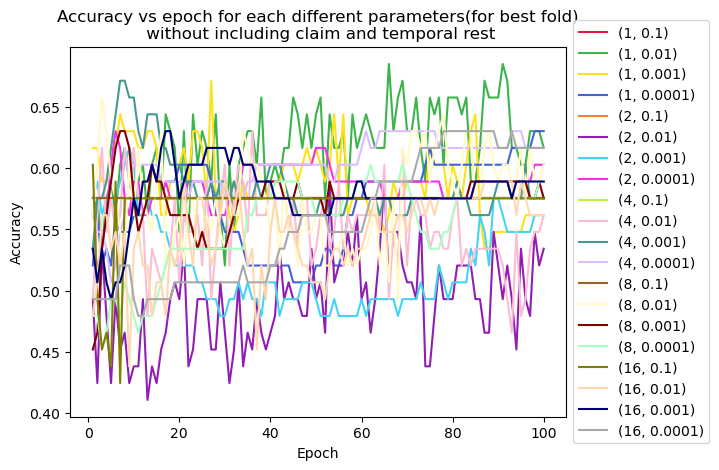

In [15]:
#By looking this graph we can say that which model gives a good accuracy. We are aware of that this plot not good at differentiate the every value.
#However, we are not using this graph to differentiate every value from the each other.
fig = plt.figure()
ax = plt.axes()
x = np.arange(NO_EPOCH)+1

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
best_idx_cvs = []
for idx in range(final_stat_s.shape[0]):
    #get best fold and draw the epoch vs accuracy
    best_idx_cvs.append(np.argmax(final_stat_s[idx][0]))
    ax.plot(x, epoch_stat_s[idx][0][best_idx_cvs[-1]], label=f'{combinations[idx]}',color=colors[idx]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Accuracy vs epoch for each different parameters(for best fold)\n without including claim and temporal rest')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [16]:
#Calculate mean result for the each different hyper parameter combination overall is 20
final_mean_s = np.mean(final_stat_s,axis=2)
print(f'Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):\n{final_mean_s}')

Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):
[[0.49863014 0.49863014 0.33422449 0.        ]
 [0.5369863  0.76506849 0.49639861 0.08366257]
 [0.50410959 0.99178082 0.50295856 0.02487286]
 [0.53424658 0.94383562 0.53381603 0.07771814]
 [0.46849315 0.50684932 0.3008067  0.        ]
 [0.50136986 0.7890411  0.46467786 0.03465581]
 [0.5260274  0.96849315 0.52682092 0.06068367]
 [0.57260274 0.88287671 0.57283599 0.15817624]
 [0.46849315 0.50684932 0.3008067  0.        ]
 [0.51506849 0.93013699 0.51208278 0.05327605]
 [0.51506849 0.99109589 0.51109013 0.04634617]
 [0.54246575 0.83561644 0.5435149  0.09659202]
 [0.50136986 0.49863014 0.34010642 0.02140872]
 [0.53972603 0.95       0.5392038  0.07847054]
 [0.50410959 0.99178082 0.50132081 0.02136165]
 [0.52328767 0.79041096 0.52266458 0.06568198]
 [0.46849315 0.50684932 0.3008067  0.        ]
 [0.52876712 0.97876712 0.52405989 0.07811141]
 [0.5260274  0.99178082 0.52592459 0.06410951]
 [0

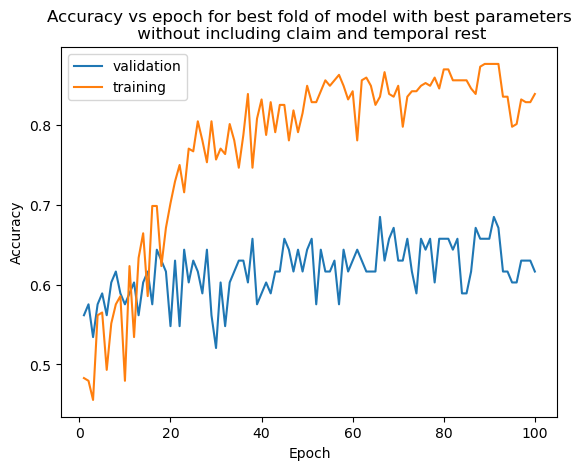

In [17]:
#we are selecting the overall best model by looking the graph
overall_best_s =1
#We are ploting the best fold result with the best parameters
fig = plt.figure()
ax = plt.axes()
#found best fold result
best_val_s =np.argmax(final_stat_s[overall_best_s][0])
y_v = epoch_stat_s[overall_best_s][0][best_val_s]
y_t = epoch_stat_s[overall_best_s][1][best_val_s]
x = np.arange(len(y_v))+1

ax.plot(x, y_v, label='validation');
ax.plot(x, y_t, label='training');

plt.title('Accuracy vs epoch for best fold of model with best parameters\n without including claim and temporal rest')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [18]:
#Calculate the best epoch result
maxIndx_s = np.argmax(epoch_stat_s[overall_best_s][0][best_val_s])

In [19]:
print(f"Our best result epoch(#{maxIndx_s})(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{epoch_stat_s[overall_best_s,:,best_val_s,maxIndx_s]}")

Our best result epoch(#65)(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.68493151 0.83561644 0.67996295 0.34486424]


In [20]:
print(f"Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{np.amax(final_mean_s, axis=0)}")

Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.57260274 0.99178082 0.57283599 0.15817624]


Text(0, 0.5, 'Accuracy')

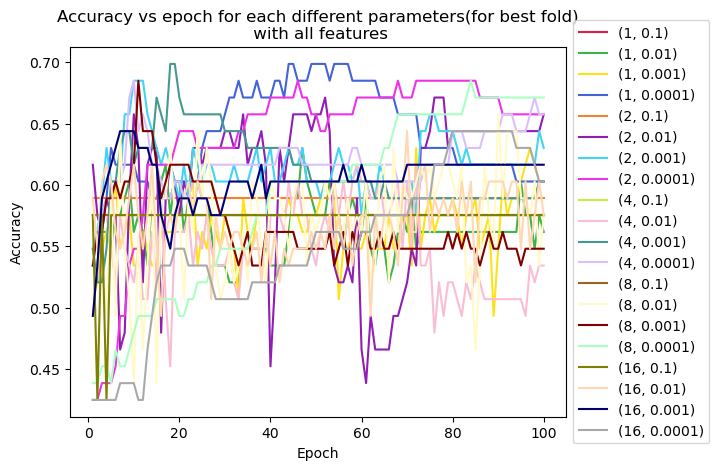

In [21]:
#By looking this graph we can say that which model gives a good accuracy. We are aware of that this plot not good at differentiate the every value.
#However, we are not using this graph to differentiate every value from the each other.
fig = plt.figure()
ax = plt.axes()
x = np.arange(NO_EPOCH)+1

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
best_idx_cvs = []
for idx in range(final_stat_s.shape[0]):
    #get best fold and draw the epoch vs accuracy
    best_idx_cvs.append(np.argmax(final_stat_e[idx][0]))
    ax.plot(x, epoch_stat_e[idx][0][best_idx_cvs[-1]], label=f'{combinations[idx]}',color=colors[idx]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Accuracy vs epoch for each different parameters(for best fold)\n with all features')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [22]:
#Calculate mean result for the each different hyper parameter combination overall is 20
final_mean_e = np.mean(final_stat_e,axis=2)
print(f'Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):\n{final_mean_e}')

Mean results for each combination(validation accuracy, training accuracy, f1 score, matthews_corrcoef):
[[ 0.49863014  0.49863014  0.33422449  0.        ]
 [ 0.51232877  0.73424658  0.48605145  0.03572104]
 [ 0.5260274   0.99178082  0.52291715  0.08034833]
 [ 0.53972603  0.97808219  0.53948584  0.08794684]
 [ 0.47123288  0.50684932  0.3068522   0.02743516]
 [ 0.5260274   0.82191781  0.51384638  0.07869579]
 [ 0.50136986  0.99178082  0.50026124  0.01514156]
 [ 0.55068493  0.93424658  0.55121276  0.10999696]
 [ 0.46849315  0.50684932  0.3008067   0.        ]
 [ 0.48219178  0.89520548  0.47311448 -0.02513986]
 [ 0.52328767  0.99178082  0.52289734  0.05534704]
 [ 0.55616438  0.87739726  0.55443372  0.13556482]
 [ 0.50136986  0.49863014  0.34012543  0.02200751]
 [ 0.52876712  0.9739726   0.52808644  0.075156  ]
 [ 0.51506849  0.99178082  0.51365831  0.0376026 ]
 [ 0.56164384  0.82123288  0.56171032  0.14228274]
 [ 0.46849315  0.50684932  0.3008067   0.        ]
 [ 0.52328767  0.96917808  0.

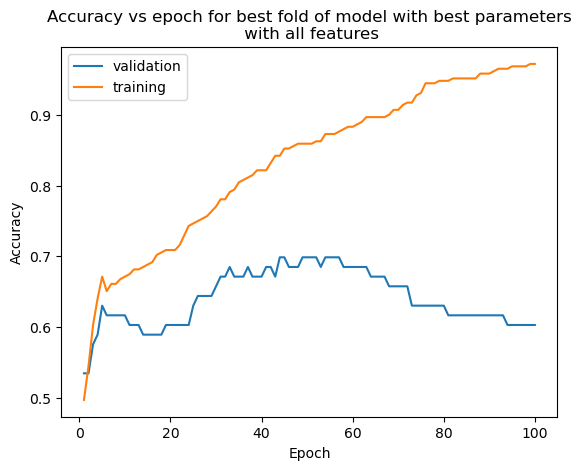

In [23]:
#we are selecting the overall best model by looking the graph
overall_best_e = 3
#We are ploting the best fold result with the best parameters
fig = plt.figure()
ax = plt.axes()
#found best fold result
best_val_e =np.argmax(final_stat_e[overall_best_e][0])
y_v = epoch_stat_e[overall_best_e][0][best_val_e]
y_t = epoch_stat_e[overall_best_e][1][best_val_e]
x = np.arange(len(y_v))+1

ax.plot(x, y_v, label='validation');
ax.plot(x, y_t, label='training');

plt.title('Accuracy vs epoch for best fold of model with best parameters\n with all features')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [24]:
#Calculate the best epoch result
maxIndx_e = np.argmax(epoch_stat_e[overall_best_e][0][best_val_e])

In [25]:
print(f"Our best result epoch(#{maxIndx_e})(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{epoch_stat_e[overall_best_e,:,best_val_e,maxIndx_e]}")

Our best result epoch(#43)(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.69863014 0.84246575 0.69919577 0.42387456]


In [26]:
print(f"Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):{np.amax(final_mean_e, axis=0)}")

Our mean result(validation accuracy, training accuracy, f1 score, matthews_corrcoef):[0.56164384 0.99178082 0.56171032 0.14228274]
